<a href="https://colab.research.google.com/github/projna/Learning-Without-Forgetting-in-Object-Detection/blob/main/lwf_objectDectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Without Forgetting in Object Detection
In the Learning without Forgetting Method, authors address the problem of adapting a vision system to a new task while preserving performance on original tasks, without access to training data for the original tasks.
In their experiment, they demonstrated the effectiveness of LwF for image classification and one experiment on tracking, but in the future work, they mentioned to do more experiments on semantic segmentation, detection.<br>
### Proposed Method:
In this experiment, we used a pretrained model Faster RCNN which is trained on Coco dataset to apply the LWF approach to solve the object detection problem. 
We created a new model by adding a new task on top of the old model. 
Then we trained our new model with PennFudan dataset.
We compared the old and new models using the PennFudan dataset after training and shown the evaluation results.

### Research Questions
* RQ1: In the object detection problem, how well a model can learn for a new task on a new dataset if modify old model with new task?
* RQ2: How do the results differ from the authors' findings?


### References: 
1. [Learning without Forgetting](https://arxiv.org/pdf/1606.09282.pdf) 
2. [TorchVision object detection](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
3. [ Object Detection Pre-Trained Model ](https://pytorch.org/vision/stable/models.html)
4. [ Object Detection Github ](https://github.com/pytorch/vision/tree/main/references/detection)
5. [ Evaluation Metrcis ](https://kharshit.github.io/blog/2019/09/20/evaluation-metrics-for-object-detection-and-segmentation)
6. [Bounding Box for "Detected Object"](https://pytorch.org/vision/stable/generated/torchvision.utils.draw_bounding_boxes.html)
7. [Coco Dataset](https://cocodataset.org/#download)
8. [ PennFudanPed Dataset ](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)
9. [Mean Average Precision and Mean Average Recall](https://torchmetrics.readthedocs.io/en/stable/detection/mean_average_precision.html)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import utils
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# from torchvision.models.detection import utils

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

# Dataset Preprocessing
The dataset contains into two parts: Image, Mask
We haven't converted the mask to RGB, because each color corresponds to a different instance with 0 being background
Convert the PIL Image into a numpy array
Instances are encoded as different colors.
Get bounding box coordinates for each mask


In [ ]:
class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    # transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [ ]:
# Create train,test and validation dataset for 
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
dataset_val= PennFudanDataset('PennFudanPed', get_transform(train=False))

In [ ]:
indices = torch.randperm(len(dataset)).tolist()
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-30])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-30:-15])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-15:])

print(dataset_val)
print(indices[:-30])
print(indices[-30:-15])
print(indices[-15:])

[164, 98, 55, 144, 140, 32, 43, 116, 139, 120, 86, 56, 114, 13, 133, 51, 34, 30, 69, 61, 123, 78, 65, 40, 76, 156, 109, 62, 17, 117, 148, 168, 60, 160, 88, 105, 166, 8, 100, 85, 122, 128, 81, 70, 38, 18, 74, 28, 111, 15, 2, 153, 147, 83, 157, 25, 97, 102, 52, 131, 50, 119, 71, 10, 5, 149, 145, 16, 163, 137, 44, 92, 27, 36, 12, 84, 68, 113, 20, 158, 106, 152, 162, 112, 48, 125, 21, 37, 146, 167, 121, 33, 142, 99, 35, 66, 110, 57, 127, 64, 1, 23, 79, 143, 0, 39, 126, 41, 9, 90, 134, 150, 58, 47, 159, 138, 6, 77, 91, 155, 141, 165, 129, 22, 19, 53, 115, 46, 169, 42, 72, 87, 31, 132, 11, 49, 151, 75, 89, 45]
[95, 3, 124, 135, 14, 82, 161, 67, 80, 103, 107, 7, 29, 104, 118]
[108, 63, 93, 136, 54, 154, 130, 94, 73, 4, 24, 59, 96, 26, 101]


In [ ]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=1,
        collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=1,
        collate_fn=utils.collate_fn)
data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=1,
        collate_fn=utils.collate_fn)

### Model Description
Employ Mask R-CNN in this model, which is built on top of Faster R-CNN. 
Load two instance segmentation model pre-trained on COCO
Get number of input features and output features for both models
Adding new class of new model out features 
Replace the pre-trained head with the newly edited out features for new model and old model remain unchanged.
Now getting the number of input features for the mask classifier and replace the mask predictor with a new hidden layer.


In [ ]:
import random
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
random.seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0
start_epoch = 1

In [ ]:
# Here we will build the model for new and old model. We will use pytorch pretrained model from pytorch
model_old = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model_new = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

In [ ]:
in_features_new = model_new.roi_heads.box_predictor.cls_score.in_features
in_features_old = model_old.roi_heads.box_predictor.cls_score.in_features
out_features_new = model_new.roi_heads.box_predictor.cls_score.out_features
out_features_old = model_old.roi_heads.box_predictor.cls_score.out_features
out_features = model_new.roi_heads.box_predictor.cls_score.out_features
print(in_features_new)
print(out_features_new)
print(in_features_old)
print(out_features_old)


1024
91
1024
91


In [ ]:
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
out_features_new=out_features_new+num_classes
print(out_features_new)
model_new.roi_heads.box_predictor = FastRCNNPredictor(in_features_new, out_features_new)
model_old.roi_heads.box_predictor = FastRCNNPredictor(in_features_old, out_features_old)

93


In [ ]:
in_features_mask_new = model_new.roi_heads.mask_predictor.conv5_mask.in_channels
in_features_mask_old = model_old.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer=256
model_new.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask_new,
                                                       hidden_layer,
                                                       out_features_new)
model_old.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask_old,
                                                       hidden_layer,
                                                       out_features_old)


In [ ]:
# CUDA
model_new = model_new.to(device)
model_old = model_old.to(device)

In [ ]:
if device == 'cuda':
    model_new = torch.nn.DataParallel(model_new)
    model_old = torch.nn.DataParallel(model_old)
    cudnn.benchmark = True

### Experiment Setup
* Optimizer: SGD with learning rate 0.005 with momentum of 0.09 and weight delay of 0.0005.
* Scheduler: For testing the best learning rate, stepLR with step size 3.
* Alpha Value: 0.01, alpha value is used for balancing the loss function
Freeze the old model parameters, so that old model could not train with the new dataset.
* Train the new model with PennFudan Dataset.
* Loss Function: alpha* new model + (1-alpha) *old model
* Number of Epochs : 50


In [ ]:

alpha = 0.01

In [ ]:
for param in model_old.parameters():
  param.requires_grad = False

In [ ]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_new.parameters()), lr=0.01,
        momentum=0.9, weight_decay=5e-4)

In [ ]:
import math
import sys
def train_one_epoch(model,model_old, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    model_old.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # print(targets)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            loss_dict_old=model_old(images,targets)
            losses = sum(loss for loss in loss_dict.values())
            losses_old=sum(loss for loss in loss_dict_old.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        loss_dict_reduced_old = utils.reduce_dict(loss_dict_old)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        losses_reduced_old = sum(loss for loss in loss_dict_reduced_old.values())

        loss_value = losses_reduced.item()
        loss_value_old = losses_reduced_old.item()
        # print("New")
        # print(loss_value)
        # print("Old")
        # print(loss_value_old)
        losses_reduced = losses_reduced*alpha+losses_old*(1-alpha)
        losses = losses*alpha+losses_reduced_old*(1-alpha)
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
        # print(losses_reduced)
        # print(losses_reduced_old)
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        # print(metric_logger)
    return metric_logger

In [ ]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox","segm"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


In [ ]:
import time
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)
    print(coco_evaluator)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()
    # print(coco_evaluator.values())

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    
    coco_evaluator.summarize()
    # print(coco_evaluator.summarize())
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [ ]:
loss=[]
loss_classifier=[]
loss_mask=[]
epochs=[]

For Training, Uncomment this part

In [ ]:
# for epoch in range(50):
#   metric_logger=train_one_epoch(model_new,model_old, optimizer, data_loader, device, epoch, print_freq=35)
#   loss.append(metric_logger.loss.value)
#   loss_classifier.append(metric_logger.loss_classifier.value)
#   loss_mask.append(metric_logger.loss_mask.value)
#   epochs.append(epoch)
# new_evaluate=evaluate(model_new, data_loader_test, device=device)
# old_evaluate=evaluate(model_new, data_loader_val, device=device)

Epoch: [0]  [ 0/70]  eta: 0:13:00  lr: 0.000155  loss: 5.5292 (5.5292)  loss_classifier: 4.1995 (4.1995)  loss_box_reg: 0.1373 (0.1373)  loss_mask: 0.9290 (0.9290)  loss_objectness: 0.0123 (0.0123)  loss_rpn_box_reg: 0.0162 (0.0162)  time: 11.1505  data: 0.1152  max mem: 8932
Epoch: [0]  [35/70]  eta: 0:01:50  lr: 0.005222  loss: 5.6192 (5.6347)  loss_classifier: 3.3100 (3.6221)  loss_box_reg: 0.2449 (0.2089)  loss_mask: 0.7635 (0.8091)  loss_objectness: 0.0422 (0.0762)  loss_rpn_box_reg: 0.0064 (0.0135)  time: 2.4165  data: 0.0088  max mem: 8932
Epoch: [0]  [69/70]  eta: 0:00:02  lr: 0.010000  loss: 5.5784 (5.6248)  loss_classifier: 0.3755 (2.2389)  loss_box_reg: 0.1678 (0.2108)  loss_mask: 0.6773 (0.7521)  loss_objectness: 0.0527 (0.0721)  loss_rpn_box_reg: 0.0091 (0.0138)  time: 1.7415  data: 0.0087  max mem: 8932
Epoch: [0] Total time: 0:02:57 (2.5286 s / it)
Epoch: [1]  [ 0/70]  eta: 0:01:14  lr: 0.010000  loss: 5.6210 (5.6210)  loss_classifier: 0.4191 (0.4191)  loss_box_reg: 0.26

In [ ]:
new_model_out="drive/My Drive/Projna/objectiondetection/newmodel.pth"
old_model_out="drive/My Drive/Projna/objectiondetection/oldmodel.pth"

Uncomment the next cell for saving the model

In [ ]:
# torch.save(model_new.state_dict(), new_model_out)
# torch.save(model_old.state_dict(), old_model_out)

In [ ]:

model_new.load_state_dict(torch.load(new_model_out))
model_new.to(device)
model_old.load_state_dict(torch.load(old_model_out))
model_old.to(device)

In [ ]:
import matplotlib.pyplot as plt

### Results of all types of Loss


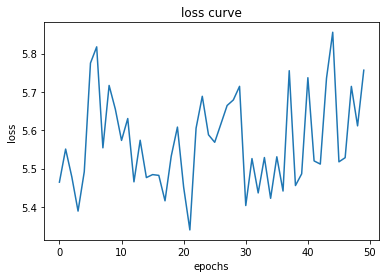

In [ ]:
# loss=[]
# loss_classifier=[]
# loss_mask=[]
# epochs=[]
# Picture of the loss changing with training
plt.figure()
plt.plot(epochs,loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('loss curve')
plt.savefig('loss.jpg')

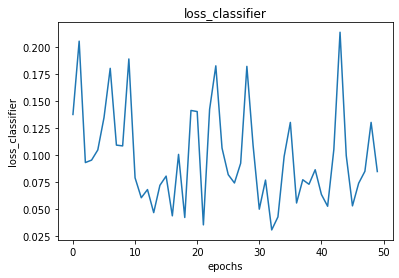

In [ ]:
# Picture of the loss_classifier changing with training
plt.figure()
plt.plot(epochs,loss_classifier)
plt.xlabel("epochs")
plt.ylabel("loss_classifier")
plt.title('loss_classifier')
plt.savefig('loss_classifier.jpg')

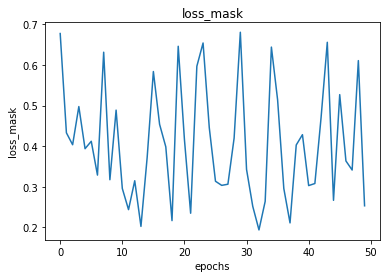

In [ ]:
plt.figure()
plt.plot(epochs,loss_mask)
plt.xlabel("epochs")
plt.ylabel("loss_mask")
plt.title('loss_mask')
plt.savefig('loss_mask.jpg')

# Draw Bounding Box around the images


In [ ]:
from PIL import Image
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes


In [ ]:
# for i in range(1):
showimageindex=1
for i in range(len(dataset_test)):
  # pick one image from the test set
  img, h = dataset_test[i]
  # print(h)
  # put the model in evaluation mode
  model_new.eval()
  with torch.no_grad():
      prediction = model_new([img.to(device)])
  objects=h['area'].size(dim=0)
  if objects>3:
    showimageindex=i
  im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  im.save("drive/My Drive/Projna/objectiondetection/ImageFolder/OriginalImage/testImage_"+str(i)+".png")
  img = read_image('drive/My Drive/Projna/objectiondetection/ImageFolder/OriginalImage/testImage_'+str(i)+'.png')
  # boxes=prediction[0]['boxes'][0]
  boxes=prediction[0]['boxes'][:objects]
  labels=objects*['Person']
  # img=draw_bounding_boxes(img, boxes.unsqueeze(0), width=3, colors=(0,0,0))
  img=draw_bounding_boxes(img, boxes, width=3, colors=(0,255,0),labels=labels,font_size=11)
  img = torchvision.transforms.ToPILImage()(img)
  img.save("drive/My Drive/Projna/objectiondetection/ImageFolder/Boximage/boximage_"+str(i)+".png")

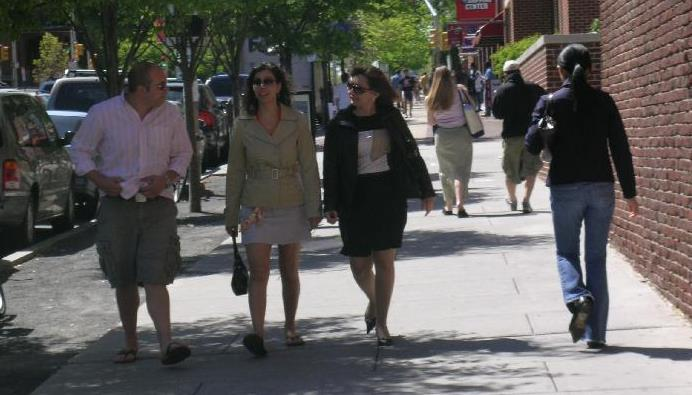

Detected Objects


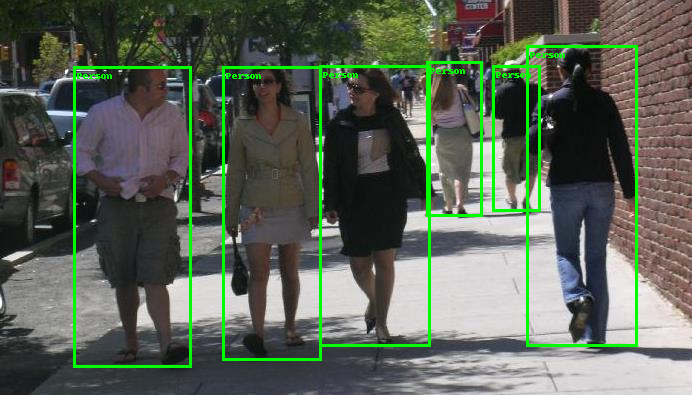

In [ ]:
from IPython.display import Image, display
display(Image("drive/My Drive/Projna/objectiondetection/ImageFolder/OriginalImage/testImage_"+str(showimageindex)+".png"))
print("Detected Objects")
display(Image("drive/My Drive/Projna/objectiondetection/ImageFolder/Boximage/boximage_"+str(showimageindex)+".png"))

### Evaluation On Individual Image 

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 13.6 MB/s 


In [ ]:

from torchmetrics.detection.mean_ap import MeanAveragePrecision
for i in range(3):
  img,target = dataset_test[i]
  targetBox=target['boxes']
  targetLabesl=target['labels']
  targetBox=targetBox.to(device)
  targetLabesl=targetLabesl.to(device)
  model_new.eval()
  with torch.no_grad():
      prediction = model_new([img.to(device)])
  preds = [dict(
          boxes=prediction[0]['boxes'],
          scores=prediction[0]['scores'],
          labels=prediction[0]['labels'])]
  target = [dict(
          boxes=targetBox,
          labels=targetLabesl)]

  metric = MeanAveragePrecision()
  metric.update(preds, target)
  from pprint import pprint
  print("################ Mean Average Precision For individual Image ########################")
  pprint(metric.compute())
  print("#####################################################################################")


################ Mean Average Precision For individual Image ########################
{'map': tensor(0.8102),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(0.8102),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.1800),
 'mar_10': tensor(0.8200),
 'mar_100': tensor(0.8200),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.8200),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}
#####################################################################################
################ Mean Average Precision For individual Image ########################
{'map': tensor(0.7505),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(0.8000),
 'map_medium': tensor(0.7000),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.4000),
 'mar_10': tensor(0.7500),
 'mar_100': tensor(0.7500),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.8000),
 'mar_medium': tenso